## Baseline Model 1: Evaluation

In [1]:
import numpy as np
import tensorflow as tf
from numpy.random import seed
from tensorflow import set_random_seed
seed(1)
set_random_seed(1)

from keras import initializers
from keras.regularizers import l2
from keras.models import Model
from keras.layers import Embedding, Input, Dense, merge, Flatten, concatenate, multiply, dot, Reshape, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
import keras.callbacks
from time import time
import pdb
from scipy import sparse
import sqlalchemy as db
from sqlalchemy import create_engine
import psycopg2
import sqlite3

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

In [3]:
import pandas as pd
import pickle

In [4]:
# DATABASE_URI = ###
# engine = create_engine(DATABASE_URI)
engine = sqlite3.connect('data/db.db', check_same_thread=False)

In [5]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [6]:
pre = "data/models/"

## User and item ids

create new encoder for sample data

In [8]:
from sklearn.preprocessing import LabelEncoder

In [7]:
#users = pd.read_sql('SELECT DISTINCT userid from target_training_enc', engine).values
#items = pd.read_sql('SELECT DISTINCT anbieter_artikelnummer from target_training_enc', engine).values

In [10]:
#user_encoder = LabelEncoder()
#user_encoder = user_encoder.fit(users)
#item_encoder = LabelEncoder()
#item_encoder = item_encoder.fit(items)

In [75]:
#users_emb = round(len(users) ** 0.25)
#items_emb = round(len(items) ** 0.25)

load encoder trained for full data set

In [ ]:
user_encoder = pickle.load(open(pre+'preprocessing/user_enc.pkl', "rb")) 
item_encoder = pickle.load(open(pre+'preprocessing/item_enc.pkl', "rb"))

In [ ]:
users_emb = round(len(user_encoder.classes_) ** 0.25)
items_emb = round(len(item_encoder.classes_) ** 0.25)

### Model

In [11]:
def get_model(layers=[50], reg_layers=[0], reg_mf=0):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    ### Input variables
    # Context
    user = Input(shape = (1,), dtype = "float32", name = "user")
    item = Input(shape = (1,), dtype = "float32", name = "item")
    # Item



    ### Embedding layer
    # MF
    # Item
    
    MF_Embedding_Item = Embedding(input_dim=len(item_encoder.classes_)+1, output_dim=25, name='mf_embedding_item',
                                  embeddings_initializer=initializers.random_normal(),
                                  embeddings_regularizer=l2(reg_mf),input_length=1)


    
    # User
    
    MF_Embedding_User = Embedding(input_dim=len(user_encoder.classes_)+1, output_dim=25, name='mf_embedding_user',
                                      embeddings_initializer=initializers.random_normal(),
                                      embeddings_regularizer=l2(reg_mf),
                                      #mask_zero = True,
                                      input_length=1)


    
    # MLP
    # item
    MLP_Embedding_Item = Embedding(input_dim=len(item_encoder.classes_)+1, output_dim=items_emb, name='mlp_embedding_item',
                                  embeddings_initializer=initializers.random_normal(),
                                  embeddings_regularizer=l2(reg_mf),input_length=1)


    
    # User
    
    MLP_Embedding_User = Embedding(input_dim=len(user_encoder.classes_)+1, output_dim=users_emb, name='mlp_embedding_user',
                                      embeddings_initializer=initializers.random_normal(),
                                      embeddings_regularizer=l2(reg_mf),
                                      #mask_zero = True,
                                      input_length=1)
    
    ## all user ones zb. and then concenate / multiply in MF 
    # MF part
    ## context 
    emb_item = Flatten(name = "mf_flat_item")(MF_Embedding_Item(item))
    
    ## user
    emb_user = Flatten(name ="mf_flat_user")(MF_Embedding_User(user))

    # MF connect
    mf_vector = multiply([emb_item, emb_user], name = "mf_multiply")
    
    
    # MLP part
    ## user
    emb_user2 = Flatten(name ="mlp_flat_user")(MLP_Embedding_User(user))

    ## item
    emb_item2 = Flatten(name = "mlp_flat_item")(MLP_Embedding_Item(item))

    mlp_vector = concatenate([emb_item2, emb_user2], name = "mlp_conc")

    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer=l2(reg_layers[idx]), activation='relu', name="layer%d" % idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = concatenate([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer=initializers.lecun_normal(),
                       name="prediction")(predict_vector)

    model_ = Model(inputs=[user, item],
                   outputs=prediction)

    return model_

In [71]:
def transform(data_bundle):
    try:
        user = user_encoder.transform(data_bundle['userid'])+1
    except:
        data_bundle.reset_index(drop = True, inplace = True)
        l_u = []
        for i in range(len(data_bundle)):
            try:
                us = user_encoder.transform(data_bundle['userid'][i:i+1])+1
                l_u.append(us[0])
            except:
                l_u.append(0)
        user = np.array(l_u)
    try:
        item = item_encoder.transform(data_bundle['anbieter_artikelnummer'])+1
    except:
        data_bundle.reset_index(drop = True, inplace = True)
        i_l =[]
        for i in range(len(data_bundle)):
            try:
                it = item_encoder.transform(data_bundle['anbieter_artikelnummer'][i:i+1])+1
                i_l.append(it[0])
            except: 
                i_l.append(0)
        item = np.array(i_l)
    return([user, item])

In [73]:
# Parameters
# Model
# MLP
layers = [128,64,32,16] #[378,162,42,14]
reg_layers = [0.001, 0.001, 0.001, 0.001] #[0.04,0.0001,0.01,0.01] #
# MF
reg_mf = 0.001 #0.0003 
#num_negatives = args.num_neg
learning_rate = 0.001

In [76]:
model = get_model(layers, reg_layers, reg_mf)

Instructions for updating:
Colocations handled automatically by placer.


In [77]:
weights_path = pre + "07_1_NeuMF_weights.h5"


In [78]:
model.load_weights(weights_path)

# Evaluation

## General Auroc

Calculate the general Roc of across all users - same as selection criteria for best model

In [79]:
query = ('''SELECT  [index], userid
            FROM    target_testing_enc''')
test_data = pd.read_sql(query, engine)

In [80]:
test_list = test_data['index'].values.tolist()

In [81]:
len(test_list)

1251313

In [ ]:
y_all = []
predict_all = []

In [87]:
for batches in range(0, len(test_list), 50000):
    indeci = tuple(test_list[batches:batches+50000])
    engine = sqlite3.connect('data/db.db', check_same_thread=False)
    query_v = f"""
        SELECT anbieter_artikelnummer, userid, pick FROM target_testing_enc where [index] IN {indeci}
    """
    data = pd.read_sql_query(query_v, engine)
    data_p = transform(data)
    # select truth and make prediction
    y_true = data.pick.values.flatten().tolist()
    y_score = model.predict(x = data_p).flatten().tolist()
    y_all.append(y_true)
    predict_all.append(y_score)
# flatten all results
flat_list_y = [item for sublist in y_all for item in sublist]
flat_list_predict = [item for sublist in predict_all for item in sublist]
# make arrays
y_array = np.array(flat_list_y, ndmin = 2).reshape(-1,1)
pred_array = np.array(flat_list_predict, ndmin =2).reshape(-1,1)

In [88]:
batches

1250000

In [89]:
len(flat_list_predict)

1251313

In [90]:
len(flat_list_y)

1251313

In [91]:
test_roc = roc_auc_score(y_array, pred_array)

In [92]:
test_roc

0.6881976804143902

### Results

In [93]:
results = pd.DataFrame({'index': test_list,
                        'userid': test_data.userid.values.tolist(),
                       'y_true': flat_list_y,
                       'y_pred': flat_list_predict})

In [94]:
results.head()

,index,userid,y_true,y_pred
0,129284,808754,0.0,0.329194
1,129285,1613118,0.0,0.071562
2,129286,1678457,0.0,0.203354
3,129287,1613118,0.0,0.029780
4,129288,1509849,0.0,0.728400


In [95]:
np.mean(results.y_true)

0.2854074080585753

In [96]:
results.to_pickle(pre + 'evaluation/07_1_test_results.pkl')

## Per User Metrics

In [97]:
results.head()

,index,userid,y_true,y_pred
0,129284,808754,0.0,0.329194
1,129285,1613118,0.0,0.071562
2,129286,1678457,0.0,0.203354
3,129287,1613118,0.0,0.029780
4,129288,1509849,0.0,0.728400


### Calc UAUC, Precision@M, und Recall@M

In [98]:
users = results.groupby('userid').agg({'index': 'count', 'y_true': 'sum'}).reset_index()

In [99]:
users.columns = ['userid', 'clicks', 'picks']

In [100]:
users.head()

,userid,clicks,picks
0,0,436,295.0
1,100099,18,3.0
2,100134,85,21.0
3,100178,1,1.0
4,100561,20,2.0


Filter users that have at least 1 pick and also one not pick - otherwise metrics are not meaningful

In [101]:
len(users)

33867

In [102]:
k = 5

In [103]:
all_user_roc = []
all_user_prec = []
all_recall = []

for u in users.userid.values.tolist(): 
    # user clicks
    data_u = results[results.userid == u].reset_index(drop=True)
    # aurco
    if len(data_u.y_true.unique()) > 1:
        roc = roc_auc_score(data_u.y_true, data_u.y_pred)
    else:
        roc = None
    all_user_roc.append(roc)
    # find top k
    data_u_top = data_u.sort_values('y_pred', ascending = False)[:k]
    # precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)
    # recal@k = (# of recommended items @k that are relevant) / (total # of relevant items)
    if sum(data_u.y_true) > 0: # otherwise recall is not defined, precision should not be punished
        prec = sum(data_u_top.y_true)/len(data_u_top)
        recall = sum(data_u_top.y_true)/sum(data_u.y_true)
    else : 
        prec = None # would always be 0 - wasn't fault of ranking but data, could myb set to 1 after
        recall = None # cannot be calculated - ranking did not miss any positives, could set to 1 after
    all_recall.append(recall)
    all_user_prec.append(prec)

----------------------------------------------

In [104]:
users['u_roc'] =all_user_roc
users['prec'] = all_user_prec
users['recall'] = all_recall

In [105]:
users.to_pickle(pre + "evaluation/07_1_test_user_results_new.pkl")

In [106]:
users = pd.read_pickle(pre +"evaluation/07_1_test_user_results_new.pkl")

### Evaluate User AUROC

In [107]:
users.sample(5)

,userid,clicks,picks,u_roc,prec,recall
26913,593632,44,16.0,0.944196,1.0,0.3125
4151,1585564,2,1.0,1.000000,0.5,1.0000
18294,1681724,13,5.0,0.762500,0.6,0.6000
24903,362166,8,0.0,NaN,NaN,NaN
391,1506587,25,5.0,0.820000,0.6,0.6000


In [108]:
len(users)

33867

In [109]:
# delete users that did not have a valid roc auc score
all_roc_clean = [x for x in users.u_roc if not pd.isnull(x)]
user_roc = sum(all_roc_clean) / len(all_roc_clean)

In [110]:
len(all_roc_clean)

22363

In [111]:
user_roc

0.6859849209727682

In [112]:
import statistics

In [113]:
statistics.median(all_roc_clean)

0.7000000000000001

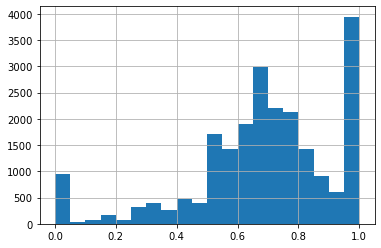

In [114]:
users.u_roc.hist(bins = 20)

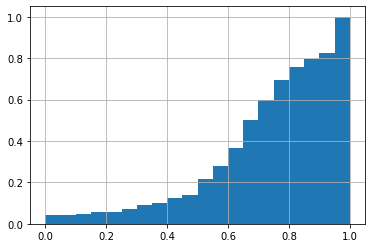

In [115]:
users.u_roc.hist(bins = 20, cumulative=True,density=1)

### Evaluate Precision@M per User

In [116]:
avg_precision = np.mean(users.prec)
avg_precision

0.53173721340388

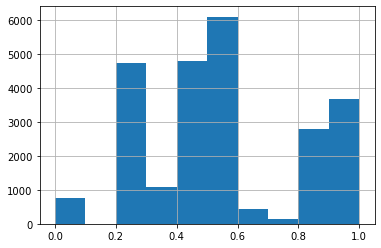

In [117]:
users.prec.hist()

In [118]:
users[pd.isna(users.u_roc) == False].prec.mean() # is a little overflattet now, because of some that are only 1

0.48552445259282445

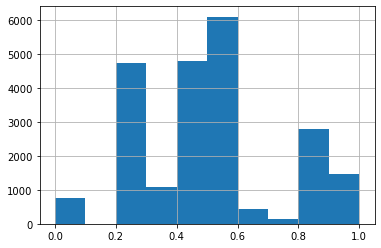

In [119]:
users[pd.isna(users.u_roc) == False].prec.hist()

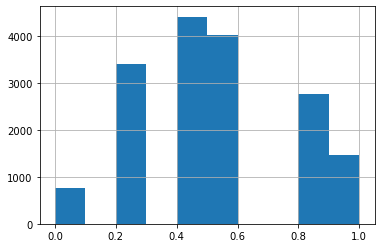

In [120]:
users[users.clicks > 5].prec.hist()

In [121]:
np.mean(users[users.clicks > 5].prec)

0.5070124308570748

### Evaluate Recall@M per User

In [122]:
avg_recall = np.mean(users.recall)
avg_recall

0.6115888365129211

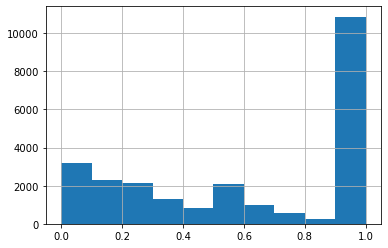

In [123]:
users.recall.hist()

In [124]:
users[users.clicks > 5].recall.mean() # is a little overflatted with users that have less than 5 

0.4323878970512383

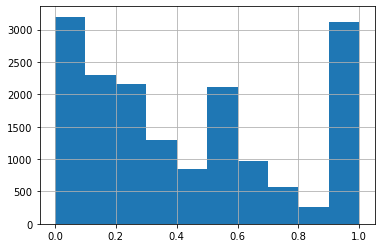

In [125]:
users[users.clicks > 5].recall.hist()

### UROC@M

Calculate UROC@M and compare the average at different values in Graph, M is max - so cutoff value, doesn't matter if user only has less

In [126]:
lists = {}
lists['all_user_roc_5'] = []
lists['all_user_roc_10'] = []
lists['all_user_roc_15'] = []
lists['all_user_roc_20'] = []

In [127]:
for u in users.userid.values.tolist(): 
    # user clicks
    data_u = results[results.userid == u].reset_index(drop=True)
    for k in [5, 10, 15, 20]:
        data_u_top = data_u.sort_values('y_pred', ascending = False)[:k]
        # aurco
        if len(data_u_top.y_true.unique()) > 1:
            roc = roc_auc_score(data_u_top.y_true, data_u_top.y_pred)
        else:
            roc = None
        k_name = 'all_user_roc_' + str(k)
        lists[k_name].append(roc)

Evaluate: Average per M

In [128]:
len(lists['all_user_roc_5'])

33867

In [129]:
all_roc_clean_5 = [x for x in lists['all_user_roc_5'] if not pd.isnull(x)]
user_roc_5 = sum(all_roc_clean_5) / len(all_roc_clean_5)

In [130]:
user_roc_5

0.6451452010794879

In [131]:
all_roc_clean_10 = [x for x in lists['all_user_roc_10'] if not pd.isnull(x)]
user_roc_10 = sum(all_roc_clean_10) / len(all_roc_clean_10)
user_roc_10

0.6547223213519666

In [132]:
all_roc_clean_15 = [x for x in lists['all_user_roc_15'] if not pd.isnull(x)]
user_roc_15 = sum(all_roc_clean_15) / len(all_roc_clean_15)
user_roc_15

0.6613333944500559

In [133]:
all_roc_clean_20 = [x for x in lists['all_user_roc_20'] if not pd.isnull(x)]
user_roc_20 = sum(all_roc_clean_20) / len(all_roc_clean_20)
user_roc_20

0.6664973016016636

In [134]:
users['u_roc_5'] = lists['all_user_roc_5']
users['u_roc_10'] = lists['all_user_roc_10']
users['u_roc_15'] = lists['all_user_roc_15']
users['u_roc_20'] = lists['all_user_roc_20']

In [135]:
users.to_pickle(pre + "evaluation/07_1_test_user_results_new_extended.pkl")

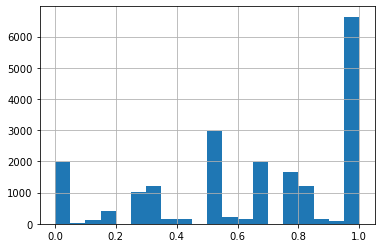

In [136]:
users['u_roc_5'].hist(bins = 20)

Graph to display results

In [137]:
all_uroc_scores = [user_roc_5, user_roc_10, user_roc_15, user_roc_20]

In [138]:
all_uroc_scores

[0.6451452010794879,
 0.6547223213519666,
 0.6613333944500559,
 0.6664973016016636]

In [139]:
M = ['5','10','15','20']

In [140]:
from matplotlib import pyplot as plt

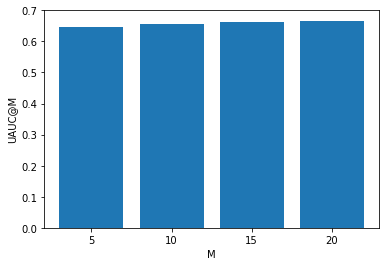

In [141]:
plt.bar(M, all_uroc_scores)
#plt.title('UAUC@M for different list length')
plt.ylabel('UAUC@M')
plt.xlabel('M')
plt.ylim(0,0.7)
plt.show()

## Compare Scores of known vs. unknown users

Evaluate, whether the average UAUC for unknown and known users - see if it can be predicted better by other model

In [23]:
import scipy

In [10]:
users_tr = user_encoder.classes_

In [11]:
users_tr_df = pd.DataFrame(users_tr)

In [15]:
users = pd.read_pickle(pre + "evaluation/07_1_test_user_results_new_extended.pkl")

In [16]:
users_j = pd.merge(users, users_tr_df, how = 'left',left_on = 'userid', right_on = 0)

In [34]:
users_j_notna = users_j[pd.notna(users_j.u_roc)]

Average UAUC for users that are not in the training data

In [36]:
np.mean(users_j_notna[pd.isna(users_j_notna[0])].u_roc)

0.6762666866752247

In [42]:
scipy.stats.sem(users_j_notna[pd.isna(users_j_notna[0])].u_roc)

0.00291099832397437

In [37]:
len(users_j_notna[pd.isna(users_j_notna[0])].u_roc)

7546

Average UAUC for users that are in the training data

In [39]:
np.mean(users_j_notna[pd.isna(users_j_notna[0]) == False].u_roc)

0.6909342221814718

In [41]:
scipy.stats.sem(users_j_notna[pd.isna(users_j_notna[0]) == False].u_roc)

0.0019218454677065672

In [40]:
len(users_j_notna[pd.isna(users_j_notna[0]) == False].u_roc)

14817

T-test for statistical significance of difference between known and unknown users:

In [43]:
scipy.stats.ttest_ind(users_j_notna[pd.isna(users_j_notna[0]) == False].u_roc, users_j_notna[pd.isna(users_j_notna[0])].u_roc)

Ttest_indResult(statistic=4.31249964696009, pvalue=1.6211031162946597e-05)